In [1]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from collections import deque
%matplotlib inline

In [2]:
def read_car_images(filep):
    '''read the car images and return an image list '''
    files = glob.glob("./vehicles/*/*")
    image_lst = []
    for filename in files:
        image = mpimg.imread(filename)
        image_lst.append(image)
    return (image_lst)


In [3]:
def read_non_car_images(filep):
    '''read non car images and return an image list'''
    files = glob.glob("./non-vehicles/*/*")
    non_car_image_lst = []
    for filename in files:
        image = mpimg.imread(filename)
        non_car_image_lst.append(image)
    return (non_car_image_lst)

In [4]:
def show_images(img_lst,img_type):
    '''read in an image list and type if car or non car and  display images'''
    print ("Number of %s images: " %img_type,len(img_lst))
    fig = plt.figure(figsize=(10,10))
    print ("%s" %img_type+" Images:")
    for i in range(6):   
        ax = fig.add_subplot(1,6,i+1)
        plt.imshow(img_lst[i])
        plt.axis("off")
    plt.savefig("./output_images/"+img_type+".jpg")

In [5]:
car_images = read_car_images("./vehicles/*/*")
non_car_images = read_non_car_images("./non-vehicles/*/*")

Number of Car images:  8792
Car Images:


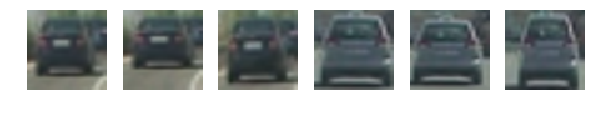

In [6]:
show_images(car_images,"Car")

Number of Non-car images:  8968
Non-car Images:


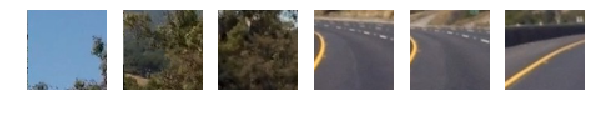

In [7]:
show_images(non_car_images,"Non-car")

In [8]:
#Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [9]:
#function to compute color histogram features
def bin_spatial(img,size=(32, 32)):    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

C:\Users\Sobha Varma\AppData\Local\conda\conda\envs\carnd-t1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


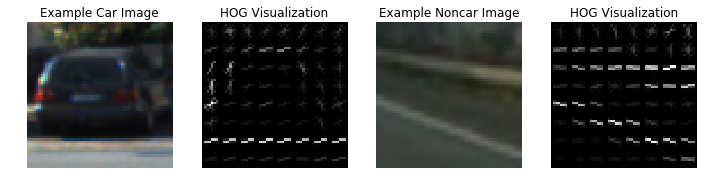

In [10]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, transform_sqrt=False,feature_vector=False)

        
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, transform_sqrt=False,feature_vector=feature_vec
                          )
        return features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_images))
# Read in the image
image = car_images[ind]
image1 = non_car_images[ind]
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray1 = cv2.cvtColor(image1,cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features,hog_image1 = get_hog_features(gray1,orient,
                        pix_per_cell,cell_per_block,
                        vis=True, feature_vec=False)

fig = plt.figure(figsize=(12,12))
plt.subplot(141)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.axis("off")
plt.subplot(142)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.axis("off")
plt.subplot(143)
plt.imshow(image1, cmap='gray')
plt.title('Example Noncar Image')
plt.axis("off")
plt.subplot(144)
plt.imshow(hog_image1, cmap='gray')
plt.title('HOG Visualization')
plt.axis("off")

plt.savefig("./output_images/Hog.jpg")

In [11]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    features = []
    #2) Apply color conversion if other than 'RGB'
    for img in imgs:
        img_features=[]
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else:    
            feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
            img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins,bins_range=hist_range)
        #6) Append features to list
            img_features.append(hist_features)
    #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
            img_features.append(hog_features)
        features.append(np.concatenate(img_features))
    #9) Return concatenated array of features
    return features

In [12]:

def get_car_notcar_features(cars,notcars):
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

    t=time.time()

    car_features = extract_features(cars, color_space=color_space, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_feat=True, hist_feat=True, hog_feat=True)
    notcar_features = extract_features(notcars, color_space=color_space, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_feat=True, hist_feat=True, hog_feat=True)
    return(car_features,notcar_features)


In [13]:
def classifier(car_features, notcar_features):
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
       scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return (svc,X_scaler)

In [14]:
cars = car_images
notcars = non_car_images
car_features,notcar_features = get_car_notcar_features(cars,notcars)
svc,X_scaler = classifier(car_features, notcar_features)

C:\Users\Sobha Varma\AppData\Local\conda\conda\envs\carnd-t1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
9.31 Seconds to train SVC...
Test Accuracy of SVC =  0.9893
My SVC predicts:  [ 1.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
0.01563 Seconds to predict 10 labels with SVC


In [15]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [16]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [17]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [18]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

C:\Users\Sobha Varma\AppData\Local\conda\conda\envs\carnd-t1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


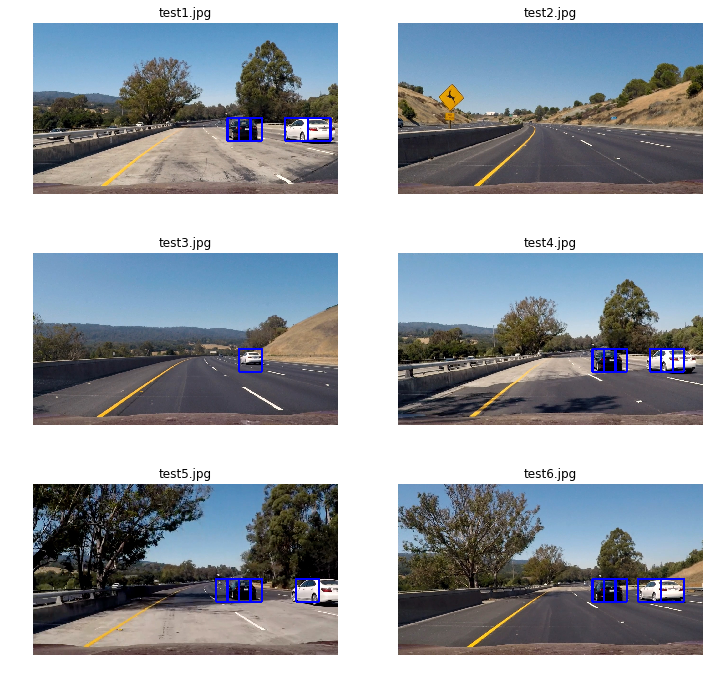

In [32]:
t=time.time()

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400,650] # Min and max in y to search in slide_window()

i=1
fig = plt.figure(figsize=(12,12))
for imgs in glob.glob('test_images/test*.jpg'):
    image = mpimg.imread(imgs)
    draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=8) 
       
    ax = fig.add_subplot(3,2,i)
    plt.imshow(window_img)
    plt.title("test"+str(i)+".jpg")
    plt.axis("off")
    i+=1
plt.savefig("./output_images/hotwindows.jpg")
    
    

    

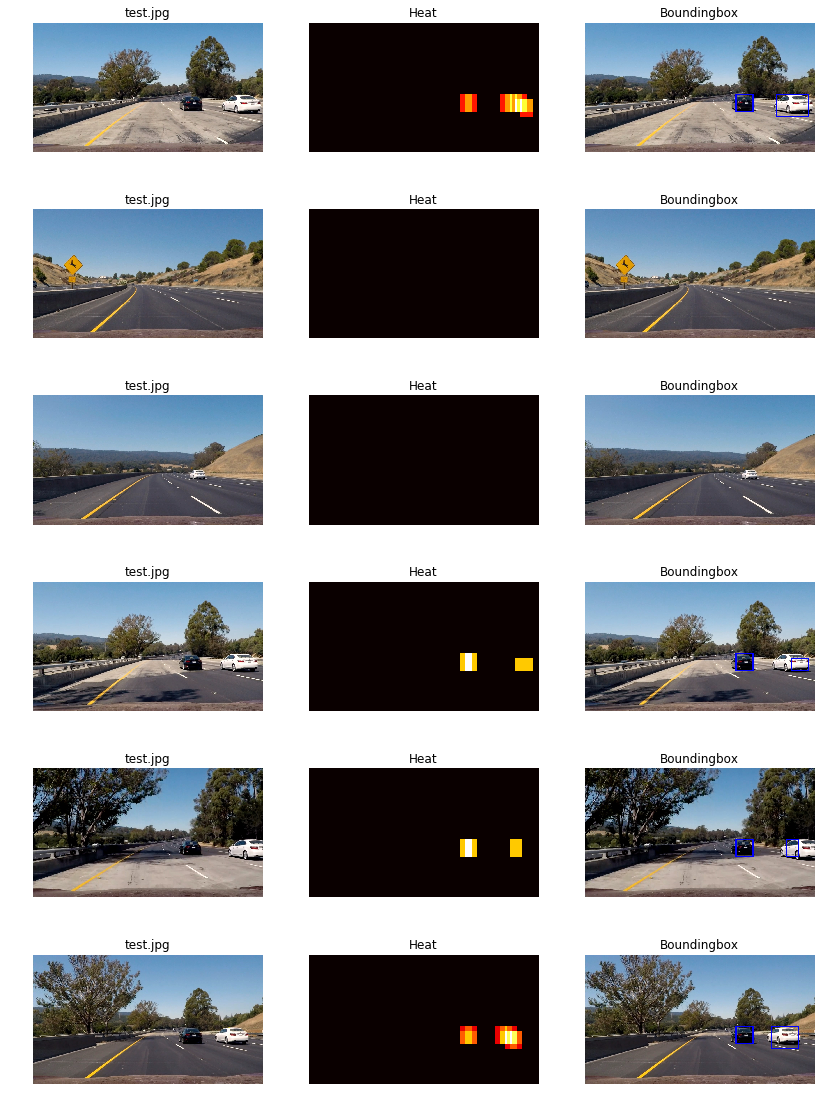

In [46]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400,650] # Min and max in y to search in slide_window()

fig = plt.figure(figsize=(14,20))
i=1
for imgs in glob.glob('test_images/test*.jpg'):
    test_img = mpimg.imread(imgs)    
    img = test_img.astype(np.float32)/255
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.7, 0.7))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    threshold = 1 
    heat = apply_threshold(heat, threshold)
    heat = np.clip(heat, 0, 255)
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(test_img),labels)
    fig.add_subplot(6,3,i)
    plt.imshow(img)
    plt.title("test.jpg")
    plt.axis("off")
    fig.add_subplot(6,3,i+1)
    plt.imshow(heat,cmap='hot')
    plt.title("Heat")
    plt.axis("off")
    fig.add_subplot(6,3,i+2)
    plt.imshow(draw_img)
    plt.title("Boundingbox")
    plt.axis("off")
    i+=3
plt.savefig("./output_images/heat.jpg")

In [44]:
##################################
htmap=deque(maxlen=12)
global htmap

def new_pipeline(image):

    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (32,32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [400,650] # Min and max in y to search in slide_window()
     

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
    
    img = image.astype(np.float32)/255
    
    windows128 = slide_window(img, x_start_stop=[600,1280], y_start_stop=y_start_stop, 
                   xy_window=(128, 128), xy_overlap=(0.7, 0.7))
    windows96 = slide_window(img, x_start_stop=[600,1280], y_start_stop=y_start_stop, 
                   xy_window=(96, 96), xy_overlap=(0.7, 0.7))
    windows64 = slide_window(img, x_start_stop=[600,1280], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7))

    
    #find all possible windows and return a list of start/end coordinates
    windows =[]
    windows.extend(windows64)
    windows.extend(windows96)
    windows.extend(windows128)

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
   
 

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    
    if (len(hot_windows) > 0):
        htmap.append(heat)    
        htmap_sum = sum(htmap)
        heat = apply_threshold(htmap_sum,14)
# Visualize the heatmap when displaying  
        heat = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
        labels = label(heat)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
    else:
        draw_img = np.copy(image)
        
    return draw_img
        
        
        


In [45]:
from moviepy.editor import VideoFileClip
video_output = "project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(new_pipeline) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [47:43<00:02,  2.22s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 47min 44s


In [20]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [21]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [22]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img